In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import quandl

# lista com ativos da carteira
ativos = ['ITUB4.SA', 'PETR4.SA', 'VALE3.SA', 'BBAS3.SA', 
          'ABEV3.SA', 'CIEL3.SA', 'EZTC3.SA', 'ECOR3.SA',
          'WEGE3.SA', 'RADL3.SA', 'OIBR3.SA']

# início e fim da extração dos dados
inicio = '2021-01-01'
fim = '2021-09-24'

precos = pd.DataFrame()

for i in ativos:
    precos[i] = yf.download(i, start= inicio, end= fim)['Adj Close']
    
# para um investimento de 20mil
compras = {'ITUB4.SA': 6000, 'PETR4.SA': 4000, 'VALE3.SA': 3000, 'BBAS3.SA': 2000, 
          'ABEV3.SA': 2000, 'CIEL3.SA': 1000, 'EZTC3.SA': 800, 'ECOR3.SA': 600,
          'WEGE3.SA': 400, 'RADL3.SA': 100, 'OIBR3.SA': 100}

compras_df = pd.Series(data= compras, index= list(compras.keys()))

# calculo do numero de papeis que compramos de cada ativo
primeiro = precos.iloc[0]

qtd_acoes = compras_df/primeiro

PL = precos*qtd_acoes

PL_filter = PL.dropna(axis= 'rows')

# coluna com o total do PL diário (soma de todas as posições)
PL_filter['PL Total'] = PL_filter.iloc[:].sum(axis = 1)

PL_filter.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,ITUB4.SA,PETR4.SA,VALE3.SA,BBAS3.SA,ABEV3.SA,CIEL3.SA,EZTC3.SA,ECOR3.SA,WEGE3.SA,RADL3.SA,OIBR3.SA,PL Total
Date,,,,,,,,,,,,
2021-01-04,6000.000000,4000.000000,3000.000000,2000.000000,2000.000000,1000.000000,800.000000,600.000000,400.000000,100.000000,100.000000,20000.000000
2021-01-05,5961.164839,4156.347200,3050.513514,1979.250006,2042.635817,976.922997,780.815306,589.584926,424.551011,99.720325,105.531920,20167.037862
2021-01-06,6135.922117,4164.648729,3150.557555,2024.474841,2083.979399,953.846056,749.160666,565.584895,435.808057,97.403106,103.829794,20465.215216
2021-01-07,6374.758714,4289.173112,3356.221190,2104.815314,2073.643380,961.538349,735.155785,570.566055,453.819322,96.164601,104.680857,21120.536678
2021-01-08,6372.815577,4305.776459,3345.724822,2117.052413,2135.659124,982.051109,775.827237,585.962245,481.265063,98.961247,103.404262,21304.499558


In [19]:
# Extrair a taxa DI diária com quandl (precisa ter uma conta e inserir a chave de API)
quandl.ApiConfig.api_key = 'SUACHAVEDEAPI'

# Na quandl, buscar a tabela 1161 que segundo o BC é a Taxa média flutuantes DI de depósitos a prazo (CDB/RDB) - Instituições financeiras
cdi = quandl.get('BCB/1161', start_date = inicio)

cdi.rename(columns={'Value': 'CDI'}, inplace=True)

cdi = cdi[~(cdi == 0).any(axis=1)]

# yfinance - baixar os dados IBOV e dólar, para usar como benchmark
benchmarks = ['^BVSP', 'USDBRL=X']

benchs = pd.DataFrame()

for i in benchmarks:
    benchs[i] = yf.download(i, start = inicio, end = fim)['Adj Close']
    
benchs = pd.merge(benchs, cdi, how='inner', on='Date')

# unir a tabela de benchmarks (CDI, IBOV, dolar) + tabela de ações da carteira
novo_df = pd.merge(benchs, PL_filter, how = 'inner', on = 'Date')

# Os dados do CDI que baixamos são uma taxa diária e não uma cota ou preço de ativo
# Para comparar com o preço de uma ação ou cateira, temos que criar um investimento fictício. Simular a criação de um CDB
# que rende 100% do CDI. Simulo que tenho R$ 1,00 no primeiro dia e esse investimento evolui diariamente de acordo com a
# oscilação da taxa DI (como um CDB real)

# loop que começa com R$ 1,00 e acumula o rendimento da taxa DI diária
# isso é uma aproximação, a taxa oficial do histórico de taxas DI deve ser obtida diretamente na B3 e a fórmula oficial
# deve ser usada, caso seja necessário rigor matemático
lista = []

for i in range(len(novo_df)):
    if i == 0:
        lista.append(1)
    else:
        lista.append((lista[i-1])*(1+(novo_df.CDI.iloc[i-1])/100))
        
novo_df['CDB_100%_CDI'] = lista

PL_normalizado = novo_df/novo_df.iloc[0]

PL_normalizado.rename(columns = {'^BVSP': 'IBOV', 'USDBRL=X': 'Dólar',
                                 'PL Total': 'Minha Carteira'}, inplace=True)

PL_normalizado[['CDB_100%_CDI']].tail()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,CDB_100%_CDI
Date,
2021-09-03,1.021852
2021-09-06,1.022065
2021-09-08,1.022271
2021-09-09,1.022474
2021-09-10,1.022689


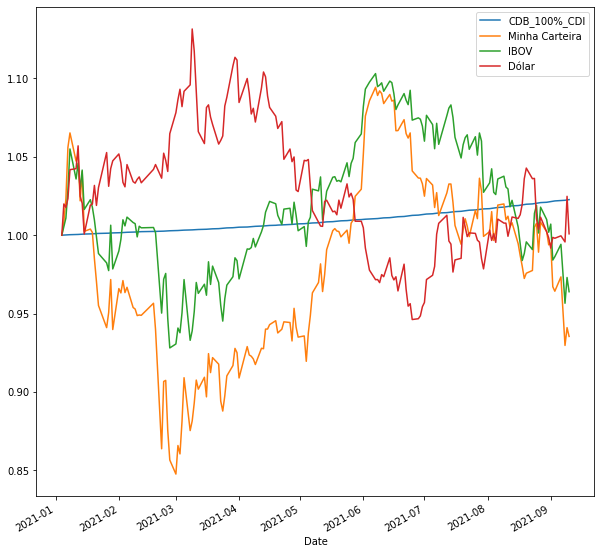

In [20]:
# PLot
PL_normalizado[['CDB_100%_CDI', 'Minha Carteira', 'IBOV', 'Dólar']].plot(figsize = (10, 10));


In [ ]:
# Fonte: https://www.instagram.com/tradingcomdados/